In [13]:
import numpy as np
import pandas as pd

In [5]:
# Q1.
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
iris = load_iris(as_frame=True)
X = iris.data           
y = iris.target          
feature_names = iris.feature_names
class_names = iris.target_names

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (120, 4) Test shape: (30, 4)


In [15]:
class GaussianNBManual:
    def fit(self, X, y, var_smoothing=1e-9):
        X = np.asarray(X)
        y = np.asarray(y)
        self.classes_, counts = np.unique(y, return_counts=True)
        self.class_prior_ = {c: cnt / len(y) for c, cnt in zip(self.classes_, counts)}
        self.theta_ = {}  
        self.sigma_ = {}  
        for c in self.classes_:
            X_c = X[y == c]
            self.theta_[c] = X_c.mean(axis=0)
            self.sigma_[c] = X_c.var(axis=0) + var_smoothing
        return self

nb_manual = GaussianNBManual().fit(X_train, y_train)

for c in nb_manual.classes_:
    print(f"class={c}, prior={nb_manual.class_prior_[c]:.3f}")
    print(" mean:", np.round(nb_manual.theta_[c],3))
    print(" var :", np.round(nb_manual.sigma_[c],3))

class=0, prior=0.333
 mean: [4.985 3.415 1.477 0.255]
 var : [0.093 0.155 0.025 0.013]
class=1, prior=0.333
 mean: [5.93  2.75  4.252 1.32 ]
 var : [0.222 0.093 0.191 0.034]
class=2, prior=0.333
 mean: [6.61 2.98 5.58 2.04]
 var : [0.457 0.122 0.324 0.07 ]


In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from math import log, pi


def gaussian_log_pdf(x, mean, var):
    return -0.5 * (np.log(2 * np.pi * var) + ((x - mean) ** 2) / var)

def predict_manual(nb, X):
    X = np.asarray(X)
    n_samples = X.shape[0]
    preds = np.zeros(n_samples, dtype=nb.classes_.dtype)
    for i in range(n_samples):
        x = X[i]
        class_log_posteriors = []
        for c in nb.classes_:
            log_prior = np.log(nb.class_prior_[c])
            log_likelihood = np.sum(gaussian_log_pdf(x, nb.theta_[c], nb.sigma_[c]))
            class_log_posteriors.append(log_prior + log_likelihood)
        preds[i] = nb.classes_[np.argmax(class_log_posteriors)]
    return preds

y_pred_manual = predict_manual(nb_manual, X_test)
print("Accuracy (manual GNB):", accuracy_score(y_test, y_pred_manual))
print("Classification report:\n", classification_report(y_test, y_pred_manual, target_names=class_names))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_manual))


Accuracy (manual GNB): 0.9666666666666667
Classification report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

Confusion matrix:
 [[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]


In [43]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred_sklearn = clf.predict(X_test)

print("Accuracy (sklearn GaussianNB):", accuracy_score(y_test, y_pred_sklearn))
print("Classification report:\n", classification_report(y_test, y_pred_sklearn, target_names=class_names))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_sklearn))


print("sklearn class prior:", clf.class_prior_)
print("sklearn theta (means):\n", np.round(clf.theta_,3))
print("sklearn var:\n", np.round(clf.var_, 3))


Accuracy (sklearn GaussianNB): 0.9666666666666667
Classification report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

Confusion matrix:
 [[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]
sklearn class prior: [0.33333333 0.33333333 0.33333333]
sklearn theta (means):
 [[4.985 3.415 1.477 0.255]
 [5.93  2.75  4.252 1.32 ]
 [6.61  2.98  5.58  2.04 ]]
sklearn var:
 [[0.093 0.155 0.025 0.013]
 [0.222 0.093 0.191 0.034]
 [0.457 0.122 0.324 0.07 ]]


In [45]:
acc_manual = accuracy_score(y_test, y_pred_manual)
acc_sklearn = accuracy_score(y_test, y_pred_sklearn)
print(f"Manual acc = {acc_manual:.4f}, sklearn acc = {acc_sklearn:.4f}")

Manual acc = 0.9667, sklearn acc = 0.9667


In [2]:
# Q2.
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()  

In [28]:
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': list(range(1, 31)),   
    'knn__weights': ['uniform', 'distance'],  
    'knn__p': [1, 2]                          
}

gs = GridSearchCV(
    pipe_knn,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
print("Best CV accuracy:", gs.best_score_)


Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best params: {'knn__n_neighbors': 17, 'knn__p': 2, 'knn__weights': 'distance'}
Best CV accuracy: 0.975


In [10]:
best_model = gs.best_estimator_
y_pred_knn = best_model.predict(X_test)

print("Test accuracy of best KNN:", accuracy_score(y_test, y_pred_knn))
print("Classification report:\n", classification_report(y_test, y_pred_knn, target_names=class_names))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_knn))


Test accuracy of best KNN: 0.9666666666666667
Classification report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

Confusion matrix:
 [[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]


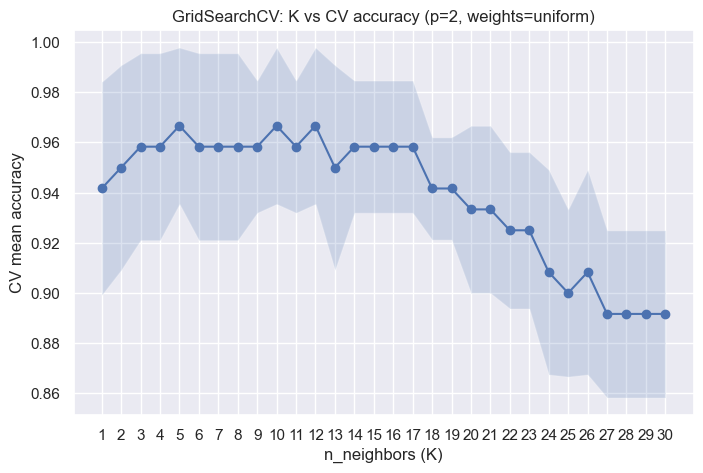

In [29]:
results = pd.DataFrame(gs.cv_results_)
subset = results[(results['param_knn__p']==2) & (results['param_knn__weights']=='uniform')]
subset = subset.sort_values(by='param_knn__n_neighbors')
plt.figure(figsize=(8,5))
plt.plot(subset['param_knn__n_neighbors'].astype(int), subset['mean_test_score'], marker='o')
plt.fill_between(subset['param_knn__n_neighbors'].astype(int),
                 subset['mean_test_score'] - subset['std_test_score'],
                 subset['mean_test_score'] + subset['std_test_score'],
                 alpha=0.2)
plt.xticks(subset['param_knn__n_neighbors'].astype(int))
plt.xlabel('n_neighbors (K)')
plt.ylabel('CV mean accuracy')
plt.title("GridSearchCV: K vs CV accuracy (p=2, weights=uniform)")
plt.grid(True)
plt.show()


In [18]:
best_k = gs.best_params_['knn__n_neighbors']
best_weights = gs.best_params_['knn__weights']
best_p = gs.best_params_['knn__p']
print(f"Best K = {best_k}, weights = {best_weights}, p = {best_p}")


Best K = 17, weights = distance, p = 2


In [30]:
from sklearn.model_selection import cross_val_score

final_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=best_k, weights=best_weights, p=best_p))
])
scores = cross_val_score(final_pipe, X, y, cv=5, scoring='accuracy', n_jobs=-1)
print("5-fold CV accuracies on full data:", np.round(scores, 4))
print("Mean accuracy:", scores.mean())


5-fold CV accuracies on full data: [0.9667 0.9667 0.9    0.9333 1.    ]
Mean accuracy: 0.9533333333333334
